In [40]:
import json
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import time

parent = 'asl-signs/'
with open(parent+'sign_to_prediction_index_map.json', 'r') as f:
    sign_to_prediction_index_map = json.load(f)

# The 'sign_to_prediction_index_map' variable now contains a Python dictionary Dict[str:int]
print(type(sign_to_prediction_index_map))
print(len(sign_to_prediction_index_map))

<class 'dict'>
250


## Data distribution

(94477, 4)
                                            path  participant_id  sequence_id  \
0  train_landmark_files/26734/1000035562.parquet           26734   1000035562   
1  train_landmark_files/28656/1000106739.parquet           28656   1000106739   
2   train_landmark_files/16069/100015657.parquet           16069    100015657   
3  train_landmark_files/25571/1000210073.parquet           25571   1000210073   
4  train_landmark_files/62590/1000240708.parquet           62590   1000240708   

    sign  
0   blow  
1   wait  
2  cloud  
3   bird  
4   owie  


<Axes: >

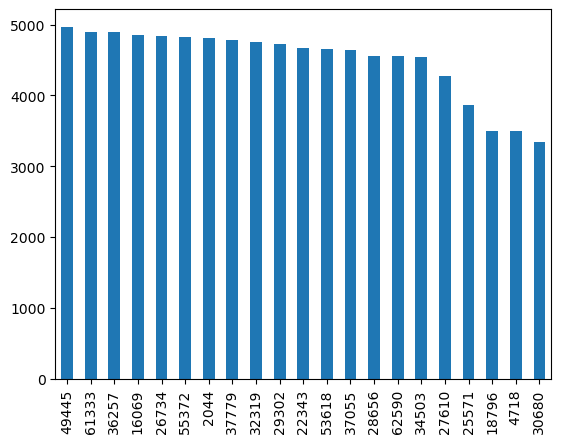

In [41]:
train = pd.read_csv(parent+'train.csv', header=0)
print(train.shape)
print(train.head())
train.participant_id.value_counts().plot(kind='bar')

In [42]:
train.groupby('sign').size().agg(['min','max','mean'])

min     299.000
max     415.000
mean    377.908
dtype: float64

In [43]:
# every sign has at least 299 samples

## Data exploration

In [44]:
import pyarrow.parquet as pq
import pandas as pd

for i in range(1):
    entry = train.iloc[0]
    path = entry.path
    participant_id = entry.participant_id
    sequence_id = entry.sequence_id
    sign = entry.sequence_id
    df = pd.read_parquet(parent+path)
#    print(df.count())
    print(df.columns.tolist())
#    print(df.type.unique())  
    for row in range(1000):
        row_values = df.iloc[row]
        print(",".join(str(value) for value in row_values.to_list()))        

['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
20,20-face-0,face,0,0.49440014362335205,0.38046982884407043,-0.030626462772488594
20,20-face-1,face,1,0.4960172474384308,0.35073480010032654,-0.05756482854485512
20,20-face-2,face,2,0.5008184909820557,0.3593430519104004,-0.030283458530902863
20,20-face-3,face,3,0.48978811502456665,0.3217797577381134,-0.040622420608997345
20,20-face-4,face,4,0.49530351161956787,0.34182101488113403,-0.06115153431892395
20,20-face-5,face,5,0.49649885296821594,0.3300192654132843,-0.05674387514591217
20,20-face-6,face,6,0.5010387897491455,0.30145734548568726,-0.028559274971485138
20,20-face-7,face,7,0.4361356794834137,0.306363582611084,0.03278343379497528
20,20-face-8,face,8,0.5017918944358826,0.2829946279525757,-0.021999457851052284
20,20-face-9,face,9,0.5010451078414917,0.27174535393714905,-0.02433554083108902
20,20-face-10,face,10,0.5014073252677917,0.22654390335083008,-0.01177428849041462
20,20-face-11,face,11,0.4947373867034912,0.385188609361

#### each face has 468 landmarks;
#### each hand has 21 landmarks;
#### each pose has 33 landmarks.

In [45]:
nlks_face = 468
nlks_hand = 21
nlks_pose = 33

In [46]:
class Frame:
    def __init__(self):
        self.face=None
        self.left_hand=None
        self.pose=None
        self.right_hand=None
    def add_face(self,face):
        self.face = face
    def add_left_hand(self,left_hand):
        self.left_hand = left_hand
    def add_pose(self,pose):
        self.pose = pose
    def add_right_hand(self,right_hand):
        self.right_hand = right_hand   

In [47]:
class Hand:
    def __init__(self, data=[[0,0]]*21,isleft=True):
        self.data = data
        self.isleft = isleft
        self.isEmpty = True
        self.isnan = False
        
    def __getitem__(self, index):
        return self.data[index]   
    
    def __setitem__(self, index, value):
        if np.isnan(value[0]) or np.isnan(value[1]): 
            self.isnan = True
            self.data[index] = [0,0]
            return
        self.data[index] = value
        self.isEmpty = False
        
    def __repr__(self):
        return ('left' if self.isleft else 'right')+ 'hand: '+ str(self.data) + str(len(self.data))
    
    def display(self):
        print(f'This is ' +('left' if self.isleft else 'right') + ' hand.')
        if self.isEmpty: 
            print(f'This hand is empty.' )
            return
        
        plt.figure()
        x_values = [x for x, y in self.data]
        y_values = [y for x, y in self.data]
        edges = [(0,1),(1,2),(2,3),(3,4),\
                 (0,5),(5,6),(6,7),(7,8),
                 (0,17),(17,18),(18,19),(19,20),\
                (9,10),(10,11),(11,12),\
                (13,14),(14,15),(15,16),\
                (5,9),(9,13),(13,17)]
        for ith,jth in edges:
            plt.plot([x_values[ith],x_values[jth]],[y_values[ith],y_values[jth]] ,marker='o')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show()
        
hand = Hand()

print(hand[0])
#hand.display()

[0, 0]


In [48]:
class Face:
    def __init__(self, data=[[0,0]]*468):
        self.data = data
        self.isEmpty = True
        self.isnan = False
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __setitem__(self, index, value):
        if np.isnan(value[0]) or np.isnan(value[1]): 
            self.isnan = True
            self.data[index] = [0,0]
            self.isEmpty = True
            return
        self.data[index] = value
        self.isEmpty = False
        
        
    def display(self):
        print('This is'+ (' an empty' if self.isEmpty else ' an')+ ' face.')
        if self.isEmpty:  return
        plt.figure()
        x_values = [x for x, y in self.data]
        y_values = [y for x, y in self.data]
        plt.scatter(x_values,y_values)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show() 

In [49]:
class Pose:
    def __init__(self, data=[[0,0]]*33):
        self.data = data
        self.isEmpty = True
        self.isnan = False
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __setitem__(self, index, value):
        if np.isnan(value[0]) or np.isnan(value[1]): 
            self.isnan = True
            self.data[index] = [0,0]
            return
        self.data[index] = value
        self.isEmpty = False
        
        
    def display(self):
        print(f'This is pose.')
        if self.isEmpty: 
            print(f'This pose is empty.' )
            return
        plt.figure()
        x_values = [x for x, y in self.data]
        y_values = [y for x, y in self.data]
        plt.scatter(x_values,y_values)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show() 

In [50]:
class Sign:
    def __init__(self):
        self.nframes=0
        self.frames=[]
        
    def add_frame(self,frame):
        self.nframes +=1
        self.frames.append(frame)
        
    def __getitem__(self, index):
        return self.frames[index]

## array dimension for hands: (# of frames, # of landmarks, 2)

In [51]:
isnoface = True
nfrms = 3
ncoord = 2
nfeatures = nfrms * ncoord * ((1-isnoface)*nlks_face + nlks_hand * 2 + nlks_pose)
print(nfeatures)

450


In [52]:
start_time = time.time()
#for i in range(train.shape[0]):
input_arr = np.zeros((0,nfeatures))
labels_arr = np.zeros((0,))
for i in range(0,100):
    arr = np.zeros(0)
    entry = train.iloc[i]
    path = entry.path
    participant_id = entry.participant_id
    sequence_id = entry.sequence_id
    signName = entry.sign
    df = pd.read_parquet(parent+path)
#    print(df.columns.tolist())
    
    frms = df.groupby('frame')
    sign = Sign()
    for idx, frm in frms:
        # create a new dataframe with the group data
        frm_df = pd.DataFrame(frm)
#        print(f'frame : {idx}')
        lefthand,righthand=Hand(isleft=True),Hand(isleft=False)
        face, pose = Face(),Pose()
        parts = frm_df.groupby('type')
        for jdx, part in parts:
# for now, we only use hand information
            part_df = pd.DataFrame(part)
            if jdx == 'left_hand':
                for _, row in part_df.iterrows():
                    lefthand[row['landmark_index']] = [row['x'],row['y']]
            elif jdx == 'right_hand':
                for _, row in part_df.iterrows():
                    righthand[row['landmark_index']] = [row['x'],row['y']]
            elif jdx == 'face':
                if not isnoface:
                    for _, row in part_df.iterrows():
                        face[row['landmark_index']] = [row['x'],row['y']]
            elif jdx == 'pose':
                for _, row in part_df.iterrows():
                    pose[row['landmark_index']] = [row['x'],row['y']]
                
#        righthand.display()                    
#       lefthand.display()
#        if not face.isEmpty:face.display()
#        if not pose.isEmpty: pose.display()

# we create a frame, ignoring pose and face for now
        frame = Frame()
        frame.add_right_hand(righthand)
        frame.add_left_hand(lefthand)
        frame.add_face(face)
        frame.add_pose(pose)
        sign.add_frame(frame)
    print(f'This sign "{signName}" has {sign.nframes} frames.')
    for i in range(sign.nframes):
        frm = sign[i]
        valid_indx = []
        if (isnoface or not frm.face.isEmpty) and (not frm.right_hand.isEmpty or not frm.left_hand.isEmpty)\
           and (not frm.pose.isEmpty):
            valid_indx.append(i)
    for ifrm in [0,len(valid_indx)//2,-1]:
        frame = sign[ifrm]
        if not isnoface:
            for iface in range(468):
                arr = np.append(arr,frame.face[iface])
        for il in range(21):
            arr = np.append(arr,frame.left_hand[il])
        for ir in range(21):
            arr = np.append(arr,frame.right_hand[ir])
        for ip in range(33):
            arr = np.append(arr,frame.pose[ip])
    input_arr = np.vstack((input_arr, arr))
    labels_arr = np.append(labels_arr, [sign_to_prediction_index_map[signName]])
print(input_arr.shape)  
print(type(input_arr))
end_time = time.time()
elapsed_time = end_time - start_time

This sign "blow" has 23 frames.
This sign "wait" has 11 frames.
This sign "cloud" has 105 frames.
This sign "bird" has 12 frames.
This sign "owie" has 18 frames.
This sign "duck" has 30 frames.
This sign "minemy" has 23 frames.
This sign "lips" has 57 frames.
This sign "flower" has 49 frames.
This sign "time" has 19 frames.
This sign "vacuum" has 33 frames.
This sign "apple" has 13 frames.
This sign "puzzle" has 19 frames.
This sign "mitten" has 141 frames.
This sign "there" has 43 frames.
This sign "dry" has 23 frames.
This sign "shirt" has 22 frames.
This sign "owl" has 100 frames.
This sign "yellow" has 22 frames.
This sign "time" has 13 frames.
This sign "not" has 18 frames.
This sign "zipper" has 13 frames.
This sign "clean" has 12 frames.
This sign "closet" has 21 frames.
This sign "quiet" has 26 frames.
This sign "have" has 6 frames.
This sign "brother" has 14 frames.
This sign "clown" has 127 frames.
This sign "cheek" has 17 frames.
This sign "cute" has 11 frames.
This sign "st

# save data to .npy file

In [56]:
np.save('inputs.npy', arr=input_arr)
np.save('labels.npy', arr=labels_arr)

In [57]:
!du -sch inputs.npy labels.npy

388K	inputs.npy
4.0K	labels.npy
392K	total


In [58]:
read_in = np.load('inputs.npy')

# Print the shape of the array
print(read_in.shape)

(100, 450)
